# Formulação de Rodrigues

**Variáveis de decisão:**
* $x_v,_c$ =
  \begin{cases}
  1, \text{se o vértice $v$ recebe a cor $c$}\\
  0, \text{caso contrário}\\
  \end{cases}

* $z_c$ =
  \begin{cases}
  1, \text{se a cor $c$ é usada}\\
  0, \text{caso contrário}\\
  \end{cases}

**Restrições**:

* Restrição de maximização

$$\Gamma_R = \max \sum_{c \in C} z_c$$

* Restrição de garatia de coloração única

$$s.a. \quad \sum_{c \in C} x_{v,c} = 1 \quad \forall v \in V$$

* Restrição de garantia que a coloração obtida será própria

$$x_{v,c} + x_{u,c} \leq z_c \quad \forall \{u,v\} \in E(G), \forall c \in C$$

* Restrição de garantia que uma cor $k$ só pode ser usada se algum vértice $v$ recebeu a cor
$k$.

$x_c \leq \sum_{v\in V} x_{v,c}  \quad  \forall c \in C$

* Restrição de garantia que a propriedade grundy.

$x_{v,c} \geq 1 - \sum_{d=1}^{c-1} x_{v,d} -\sum_{u\in N(v)} x_{u,c}  \quad  \forall v\in V(G), c\in C$

* Restrição que etabelece que os vértices isolados devem receber a
primeira cor.

$x_{v,1}=1  	\quad	\forall v\in V(G) | N(v)=0$

* Restrição que assegura que as primeiras cores serão usadas.

$x_c < x_{c-1}  	\quad	\forall c\in {2,...,|C|}$

* 

$x_{v,c}\in {0,1}  	\quad	\forall v\in V(G), c\in C$

*

$x_c \geq 0  	\quad	\forall c \in C$



In [1]:
# Instalação de pacotes necessários para execução do código
%pip install ortools
%pip install networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


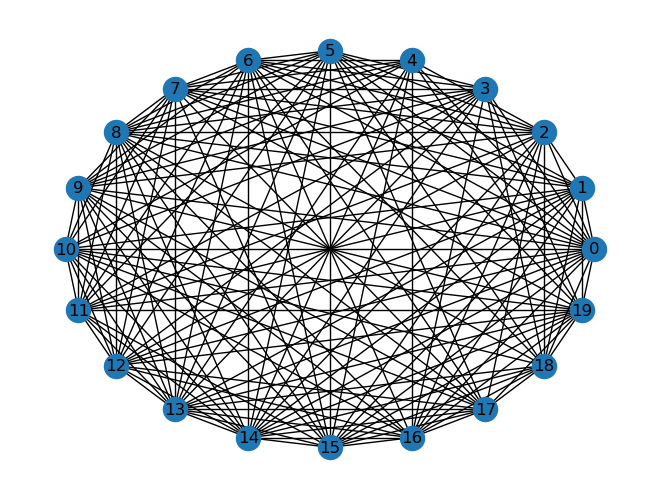

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.gnp_random_graph(20, 0.8)
nx.draw_circular(G, with_labels=True)
plt.show()

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# Array de 100 cores fornecido
color_array = [
    "gold", "red", "violet", "pink", "limegreen", "violet", "darkorange",
    "blue", "teal", "indigo", "crimson", "turquoise", "coral", "maroon",
    "olive", "navy", "magenta", "salmon", "fuchsia", "chartreuse", "skyblue",
    "beige", "sienna", "lavender", "aquamarine", "plum", "steelblue", "khaki",
    "moccasin", "peru", "chocolate", "orchid", "slateblue", "forestgreen",
    "seagreen", "tomato", "turquoise", "mediumvioletred", "cadetblue", "darkcyan",
    "palevioletred", "dodgerblue", "lightseagreen", "lightsalmon", "darkslategray",
    "darkmagenta", "yellowgreen", "mediumpurple", "lightcoral", "springgreen",
    "darkorchid", "powderblue", "rosybrown", "darkgoldenrod", "palegreen", "hotpink",
    "palegoldenrod", "mistyrose", "lightpink", "lime", "midnightblue", "darkseagreen",
    "indianred", "lightgreen", "darkolivegreen", "sandybrown", "mediumslateblue",
    "lightsteelblue", "firebrick", "greenyellow", "lightcyan", "thistle", "lawngreen",
    "royalblue", "seashell", "darkkhaki", "lightskyblue", "navajowhite", "lavenderblush",
    "cornflowerblue", "goldenrod", "darkblue", "darkturquoise", "mediumspringgreen",
    "wheat", "papayawhip", "lightgoldenrodyellow", "peru", "bisque", "peachpuff",
    "lemonchiffon", "lightgray", "mediumorchid", "darkred", "burlywood", "slategray",
    "mediumseagreen", "antiquewhite", "honeydew", "mintcream"
]

vertices = list(G.nodes())
n = len(vertices)

# Verificar se o grafo foi corretamente inicializado
if n == 0:
    raise ValueError("O grafo não foi inicializado corretamente.")

# Imprimir os vizinhos de cada vértice
print("Vizinhos de cada vértice:")
for v in vertices:
    vizinhos = list(G.neighbors(v))
    print(f"Vértice {v}: {vizinhos}")

# Inicializando o solver
solver = pywraplp.Solver.CreateSolver('CBC')

# Verificar se o solver foi corretamente inicializado
if not solver:
    raise ValueError("O solver não foi inicializado corretamente.")

# Definir o tempo máximo de execução para o solver (30 minutos)
solver.SetTimeLimit(1800 * 1000)  # 1800 segundos em milissegundos

# Variáveis de decisão x[v, c]: 1 se o vértice v recebe a cor c, 0 caso contrário
x = {}
num_colors = len(color_array)  # Número de cores é o tamanho do array de cores fornecido
for v in vertices:
    for c in range(1, num_colors + 1):
        x[v, c] = solver.BoolVar(f'x[{v},{c}]')

# Variáveis z_c: 1 se a cor c é usada, 0 caso contrário
z = {}
for c in range(1, num_colors + 1):
    z[c] = solver.BoolVar(f'z[{c}]')

# Função objetivo: minimizar o número de cores usadas
solver.Minimize(solver.Sum(z[c] for c in range(1, num_colors + 1)))

# 1. Restrição de coloração única: cada vértice recebe exatamente uma cor
for v in vertices:
    solver.Add(solver.Sum(x[v, c] for c in range(1, num_colors + 1)) == 1)

# 2. Restrição de coloração própria: vértices adjacentes não podem ter a mesma cor
for v in vertices:
    for u in G.neighbors(v):  # Para cada vizinho u de v
        if v < u:  # Evitar duplicação de restrições
            for c in range(1, num_colors + 1):
                solver.Add(x[v, c] + x[u, c] <= z[c])

# 3. Uma cor só pode ser usada se for atribuída a pelo menos um vértice
for c in range(1, num_colors + 1):
    solver.Add(z[c] <= solver.Sum(x[v, c] for v in vertices))

# 4. Propriedade de Grundy
for v in vertices:
    for c in range(2, num_colors + 1):
        solver.Add(x[v, c] >= 1 - solver.Sum(x[v, d] for d in range(1, c)) - solver.Sum(x[u, c] for u in G.neighbors(v)))

# 5. As cores devem ser usadas em ordem
for c in range(2, num_colors + 1):
    solver.Add(z[c] <= z[c - 1])

# 6. Vértices isolados devem receber a primeira cor
for v in vertices:
    if len(list(G.neighbors(v))) == 0:
        solver.Add(x[v, 1] == 1)

# Resolver o problema
print("Resolvendo o problema...")
status = solver.Solve()

# Verificar o status da solução
color_map = []

if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())

    for v in vertices:
        for c in range(1, num_colors + 1):
            if x[v, c].solution_value() == 1:
                print(f"Vértice {v} recebeu a cor {c}")
                color_map.append(color_array[c-1])  # Mapeia o índice da cor para o color_map

    # Plotar o grafo colorido
    plt.figure(figsize=(8, 6))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=700, font_color="white", font_size=12)
    plt.title('Grafo com Coloração Grundy')
    plt.show()

elif status == pywraplp.Solver.FEASIBLE:
    print('A feasible solution was found within the time limit.')
    print('Objective value =', solver.Objective().Value())

    for v in vertices:
        for c in range(1, num_colors + 1):
            if x[v, c].solution_value() == 1:
                print(f"Vértice {v} recebeu a cor {c}")
                color_map.append(color_array[c-1])  # Mapeia o índice da cor para o color_map

    # Plotar o grafo colorido
    plt.figure(figsize=(8, 6))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=700, font_color="white", font_size=12)
    plt.title('Grafo com Coloração Grundy')
    plt.show()

else:
    print('The problem does not have an optimal solution within the time limit.')

# Informações avançadas do solver
print('\nAdvanced usage:')
print('Problem solved in %f seg' % (solver.WallTime()/1000))
print('Problem solved in %d iterations' % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())


Vizinhos de cada vértice:
Vértice 0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19]
Vértice 1: [0, 2, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19]
Vértice 2: [0, 1, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18]
Vértice 3: [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19]
Vértice 4: [0, 2, 6, 7, 8, 9, 10, 13, 14, 15, 16, 19]
Vértice 5: [0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19]
Vértice 6: [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
Vértice 7: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 17, 19]
Vértice 8: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Vértice 9: [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 19]
Vértice 10: [0, 1, 3, 4, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
Vértice 11: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 19]
Vértice 12: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 19]
Vértice 13: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
Vértice 14: [0, 1, 2, 3, 4, 5, 6